# Running a multilevel sweep parameter study with PhysiCOOL


In [3]:
%matplotlib inline
from typing import List
from pathlib import Path

import numpy as np

from physicool.config import ConfigFileParser
from physicool.optimization import PhysiCellBlackBox
from physicool.processing import Cells

def params_updater(new_values: List[float]) -> None:
    """
    Updates the cell speed and the migration bias.

    Parameters
    ----------
    new_values: list[float]
        The parameter values for (1) the cell speed,
        and (2) the migration bias.

    cell_data: config.CellParameters
        The cell definition data to be updated.
    """
    cell_definition_name = "cancer"

    # Read the data from the file
    xml_parser = ConfigFileParser()
    cell_data = xml_parser.read_cell_data(cell_definition_name)

    # Update values
    cell_data.motility.speed = new_values[0]
    cell_data.motility.bias = new_values[1]
    xml_parser.update_params("cancer", cell_data)

def output_processor(output_path: Path) -> np.ndarray:
    cells = Cells(time=0, storage_path=output_path)
    coordinates = cells.get_cell_positions()
    
    return np.array([coord[1] for coord in coordinates])

my_model = PhysiCellBlackBox(params_updater, output_processor)

## Generating data (optional)
We do not have any data, so we need to generate some datasets. This step could be replaced by loading some target data from a file, though. However, it is important to make sure that the data fits the model output format!

In [4]:
params = [3.0, 0.8]
target_data = my_model.run(params)

cell_definitions/cell_definition[@name='cancer']/phenotype/secretion/substrate[@name='oxygen']
Using config file ./config/PhysiCell_settings.xml ... 
1
dc? 1
User parameters in XML config file: 
Bool parameters:: 

Int parameters:: 
random_seed: 0 [dimensionless]
number_of_cells: 0 [none]

Double parameters:: 

String parameters:: 


which boundaries?
1 1 1 1 1 1

Microenvironment summary: microenvironment: 

Mesh information: 
type: regular Cartesian
Domain: [-500,500] micron x [-500,500] micron x [-500,500] micron
   resolution: dx = 20 micron, dy = 20 micron, dz = 1000 micron
   voxels: 2500
   voxel faces: 0
   volume: 1e+09 cubic micron
Densities: (1 total)
   oxygen:
     units: dimensionless
     diffusion coefficient: 100000 micron^2 / min
     decay rate: 10 min^-1
     diffusion length scale: 100 micron
     initial condition: 0 dimensionless
     boundary condition: 38 dimensionless (enabled: true)

virtual_wall_at_domain_edge: enabled
Processing cancer ... 
Note: setting ce

In [5]:
target_data

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,  -50.,  -50.,  -50.,  -50.,  -50.,  -50.,
        -50.,  -50.,  -50.,  -50.,  -50.,  -50.,  -50.,  -50.,  -50.,
        -50.,  -50.,  -50.,  -50.,  -50.,  -50.,   50.,   50.,   50.,
         50.,   50.,   50.,   50.,   50.,   50.,   50.,   50.,   50.,
         50.,   50.,   50.,   50.,   50.,   50.,   50.,   50.,   50.,
        100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,
        100.,  100.,  100.,  250.,  250.,  250.,  250.,  250.,  250.,
        250.,  250.,  250.,  250.,  250.,  250.,  250.,  250.,  250.,
        250.,  250.,  250.,  250.,  250.,  250.,  200.,  200.,  200.,
        200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,
        200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,  200.,
       -300., -300.,

## Running the multilevel sweep pipeline

### The calibration model
First of all, **we need to define our "black-box"**. PhysiCOOL can help us do this, using `OptModel`.

`OptModel` will create a black-box function that **takes in a parameters dictionary**, **runs a PhysiCell simulation** with the updated parameter values and then **computes the metric you select** when initializing the model

You can **call this function independently**, and it will output an array with the values for the metric you choose. Here, we will be using it **inside our multilevel parameter sweep**.

In [42]:
# Create our multisweep pipeline
number_of_levels = 5
points_per_direction = 10
percent_per_direction = 1.0

ms = MultiSweep(my_model, target_data, n_levels=number_of_levels, 
                npdir=points_per_direction, ppdir=percent_per_direction)

# Choose the models to vary (use the physicool naming format)
ms.select_params('cell/migration_bias', 'cell/speed')
# Select initial value for the parameter sweep
ms.set_fit_value(0.5, 2)
ms.set_param_bounds((0, 1), (0, None))

# Run multisweep and get optimal parameters
x, y = ms.run_sweep()

# Create our PhysiCell-based pipeline
metric = 'position_y'
project_name = 'project'

my_model = OptModel(metric, project_name).create_model()

### The multisweep pipeline
The `MultiSweep` class will let you run a **multilevel parameter sweep in which the parameter bounds are iteratively adapted based on the minimum value found at each level**. To create it, you must **select the model you want to run at each level** (our `OptModel` blackbox), as well as the **target data** you want to use.

Additionally, you can tune the **number of levels**, and the **number of points and ranges to explore at each level**.

In [96]:
# Create our multisweep pipeline
number_of_levels = 5
points_per_direction = 10
percent_per_direction = 1.0

ms = MultiSweep(my_model, 
                target_data, 
                n_levels=number_of_levels, 
                npdir=points_per_direction,
                ppdir=percent_per_direction)

In addition to initializing your `MultiSweep` object, you also need to tell it **which parameters to change** and the **first value to start your search**. Optionally, you can also provide **parameter bounds**.

In [ ]:
# Choose the models to vary (use the physicool naming format)
ms.select_params('cell/migration_bias', 'cell/speed')
# Select initial value for the parameter sweep
ms.set_fit_value(0.5, 2)
ms.set_param_bounds((0, 1), (0, None))

`MultiSweep` will perform the multilevel sweep while simultaneously plotting the parameter space and using a colormap to represent the objective function. The plot is updated at each level, which provides a nice representation of how the search is evolving.

<IPython.core.display.Javascript object>


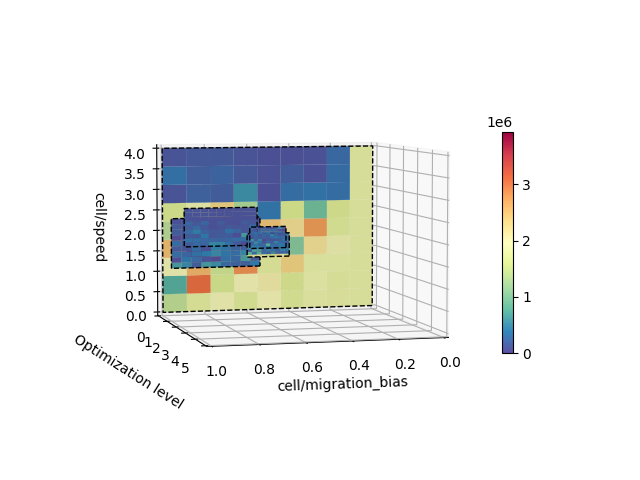

In [97]:
# Run multisweep and get optimal parameters
x, y = ms.run_sweep()

In [98]:
print(f'Optimal value found: {x}; {y}')

Optimal value found: 0.7507901831328138; 1.920450570107634
